Uncover how relationships vary across Singapore, i.e. spatial non-stationarity.

**Introduction (GWR)**

GWR extends the OLS idea by allowing coefficients to vary spatially instead of remaining constant across the entire study area.

$$y_{i} = \beta_{0}\left(u_{i}, v_{i}\right) + \sum_{k=1}^{K} \beta_{k} \left(u_{i}, v_{i}\right) x_{i k} + \varepsilon_{i}$$

where:
- $(u_{i}, v_{i})=$coordinates (X, Y in EPSG:3414)
- $\beta_{k} \left(u_{i}, v_{i}\right)=$ local coefficient estimated by giving higher weights to nearby observations.

Each location gets its own regression equation, so the model captures **spatial heterogeneity** -- e.g., "MRT proximity matters more in central than in eastern estates."

In [1]:
# mgwr: a modern implementation built atop PySAL
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# scale all numeric predictors
from sklearn.preprocessing import StandardScaler

# Moran
from esda.moran import Moran
from libpysal.weights import KNN

In [2]:
HDB_path = "processed_n\hdb_ols.parquet"
hdb = gpd.read_parquet(HDB_path)
hdb.head(2)

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,resale_year,resale_age,...,model_Model A2,model_Multi Generation,model_New Generation,model_Premium Apartment,model_Premium Apartment Loft,model_Simplified,model_Standard,model_Terrace,model_Type S1,model_Type S2
0,2023-01,ANG MO KIO,2 ROOM,01 TO 03,44.0,Improved,1979,267000.0,2023,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01,ANG MO KIO,2 ROOM,04 TO 06,49.0,Improved,1977,300000.0,2023,46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# dependent variable
y = hdb['log_price'].values.reshape((-1, 1))
# y.shape

# independent variables (numerical only; dummies oprional)
X = hdb[['floor_area_sqm', 'resale_age', 'storey_mid', 'dist_mrt', 'dist_hcen', 'dist_scen', 'bus_count_400m']].values
# X.shape

# coordinates
coords = np.column_stack([hdb['X'], hdb['Y']])

In [4]:
# Tips: scale all numeric predictors for better numerical stability
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# X_std

In [6]:
X_std[1]

array([-1.95615456,  1.39410299, -0.64355908, -0.89966755,  0.52975459,
       -0.77930073, -0.03652903])

In [6]:
"""
Select the optimal bandwidth
Bandwidth determines how far the local weighting extends.
too small: noisy local estimates.
too large: model becomes global again.
"""
bw_selector = Sel_BW(coords, y, X_std, spherical=False)
opt_bw = bw_selector.search(bw_min=50)
print("Optimal bandwidth:", opt_bw)

Optimal bandwidth: 87.0


In [7]:
# Fit the GWR model
gwr = GWR(coords, y, X_std, bw=opt_bw, kernel='bisquare', fixed=False)
gwr_results = gwr.fit()

In [8]:
# Inspect summary
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               25760
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            537.635
Log-likelihood:                                                   13285.985
AIC:                                                             -26555.970
AICc:                                                            -26553.963
BIC:                                                            -261014.566
R2:                                                                   0.762
Adj. R2:                                                              0.762

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [9]:
# Extract local results
local_params = gwr_results.params # arrary [n_obs, n_vars+1] including intercept
local_R2 = gwr_results.localR2

# Make a GeoDataFrame
gwr_gdf = hdb.copy()
gwr_gdf['local_R2'] = local_R2

# 'floor_area_sqm', 'resale_year', 'storey_mid', 'dist_mrt', 'dist_hcen', 'dist_scen', 'bus_count_400m'
for i, col in enumerate(['Intercept', 'floor_area_sqm', 'resale_year', 'storey_mid', 'dist_mrt',
                        'dist_hcen', 'dist_scen', 'bus_count_400m']):
    gwr_gdf[f'beta_{col}'] = local_params[:, i]
gwr_gdf.to_parquet("output/gwr_results.parquet")

In [11]:
"""
Compare to your global OLS — a notably lower AICc and higher Adj-R² indicate GWR fits better.
"""
print("Global R^2:", gwr_results.R2)
print("Adj R^2:", gwr_results.adj_R2)
print("AICc:", gwr_results.aicc)

Global R^2: 0.977721812399423
Adj R^2: 0.9736949677989258
AICc: -78222.56165187353


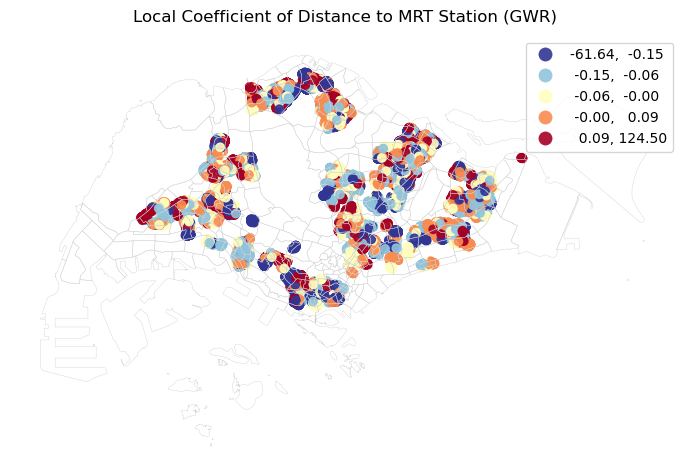

In [26]:
# Visualize spatial variation of coefficients
PLAN_PATH = "processed/mp19_subzones_3414.geojson"
pla = gpd.read_file(PLAN_PATH)

fig, ax = plt.subplots(figsize=(7,7))

gwr_gdf.plot(
    ax=ax,
    column='beta_dist_mrt',
    cmap='RdYlBu_r',
    scheme='Quantiles',
    k=5,
    legend=True,
    alpha=0.9
)

pla.boundary.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.3)

ax.set_title("Local Coefficient of Distance to MRT Station (GWR)", fontsize=12, pad=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Interpretation

Negative (blue): price decreases sharply with distance, MRT proximity highly valued.
Positive (red): weaker MRT influence, maybe areas wih alternative amenities or lower demand elasticity.

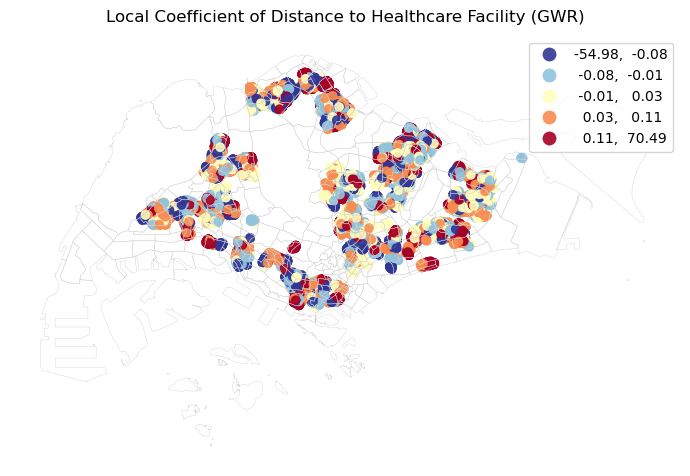

In [27]:
fig, ax = plt.subplots(figsize=(7,7))

gwr_gdf.plot(
    ax=ax,
    column='beta_dist_hcen',
    cmap='RdYlBu_r',
    scheme='Quantiles',
    k=5,
    legend=True,
    alpha=0.9
)

pla.boundary.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.3)

ax.set_title("Local Coefficient of Distance to Healthcare Facility (GWR)", fontsize=12, pad=10)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [29]:
# We should confirm that GWR has actually reduced spatial autocorrelation
w = KNN.from_dataframe(gwr_gdf, k=8)
w.transform = 'R'
mi = Moran(gwr_results.resid_response, w)
print("Moran's I of GWR residuals:", mi.I, 'P-value:', mi.p_sim)

C:\Users\METAYJ\AppData\Local\ESRI\conda\envs\ge5219\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 504 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I of GWR residuals: -0.05646480138809085 P-value: 0.001


**Compare to OLS residuals**

| Model   | Moran’s I (residuals) | p-value | Interpretation                                                                                                                                                                                     |
| ------- | --------------------- | ------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **OLS** | **0.783**             | 0.001   | Very strong **positive spatial autocorrelation** — residuals are highly clustered; nearby HDB flats have similar over- or under-predictions. The global model cannot capture localized variations. |
| **GWR** | **–0.056**            | 0.001   | Spatial autocorrelation has almost vanished (and even slightly negative). The model residuals are now **spatially random**, meaning local effects have been successfully captured.                 |

**Conclusion**
- The large drop from +0.783 to -0.056 means GWR has eliminated most spatial structure in model errors.
- We have statistically confirmed that spatial non-stationarity was present, and GWR's local coefficients now account for those regional differences.


In [ ]:
hdb.columns

In [ ]:
y.shape